# Raster Vectorization Project

In [206]:
import numpy as np
import skimage.io
import os
import random
from matplotlib import pylab
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

filename = 'C:/Users/Ashley/Documents/GitHub/image-rgb-in-3D/gradientbox.png'
img = skimage.io.imread( filename )

In [207]:
%matplotlib inline
%store img

Stored 'img' (ndarray)


In [208]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python2  %%py

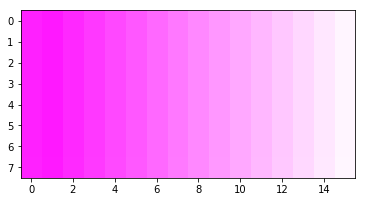

In [209]:
plt.imshow(img)

# Convert Image Array to 6D with X, Y, R, G, B, A

In [210]:
height, width, depth = img.shape
# print(img.shape)
# np.meshgrid( width, height )
# print(np.meshgrid(width, height))
# imageArray = np.append( np.meshgrid( width, height ), img )
# print(imageArray)


heightAr = list(range(0, height))
# print(heightAr)
widthAr = list(range(0, width))
# print(widthAr)
meshGrid = np.meshgrid(widthAr, heightAr)
imageArray = np.concatenate((meshGrid[0][:, :, None], meshGrid[1][:, :, None], img), axis = 2)
# print(imageArray[0, 2])
# print(imageArray.shape)

# reshaped is the input for the plane-fitting
reshaped = imageArray.reshape(width * height, -1)
print(reshaped)




[[  0   0 255  10 255 232]
 [  1   0 255  24 255 255]
 [  2   0 255  40 255 255]
 [  3   0 255  56 255 255]
 [  4   0 255  72 255 255]
 [  5   0 255  87 255 255]
 [  6   0 255 104 255 255]
 [  7   0 255 120 255 255]
 [  8   0 255 136 255 255]
 [  9   0 255 151 255 255]
 [ 10   0 255 168 255 255]
 [ 11   0 255 183 255 255]
 [ 12   0 255 199 255 255]
 [ 13   0 255 215 255 255]
 [ 14   0 255 231 255 255]
 [ 15   0 255 245 255 231]
 [  0   1 255  10 255 232]
 [  1   1 255  24 255 255]
 [  2   1 255  40 255 255]
 [  3   1 255  56 255 255]
 [  4   1 255  72 255 255]
 [  5   1 255  87 255 255]
 [  6   1 255 104 255 255]
 [  7   1 255 120 255 255]
 [  8   1 255 136 255 255]
 [  9   1 255 151 255 255]
 [ 10   1 255 168 255 255]
 [ 11   1 255 183 255 255]
 [ 12   1 255 199 255 255]
 [ 13   1 255 215 255 255]
 [ 14   1 255 231 255 255]
 [ 15   1 255 245 255 231]
 [  0   2 255  10 255 232]
 [  1   2 255  24 255 255]
 [  2   2 255  40 255 255]
 [  3   2 255  56 255 255]
 [  4   2 255  72 255 255]
 

In [224]:

# print(reshaped.shape)

# xyg = reshaped[:, [0, 1, 3]]
# print(xyg)

# prints out the channel that is wanted with the xy coordinates
def getChannel(imageArray, channel):
    xyc = [0, 1, channel]
    return imageArray[:, xyc]

# channel constants
r = 2
g = 3
b = 4
a = 5

print (getChannel(reshaped, b))
# noAlpha = reshaped[:, :5]
# print(noAlpha)

[[  0   0 255]
 [  1   0 255]
 [  2   0 255]
 [  3   0 255]
 [  4   0 255]
 [  5   0 255]
 [  6   0 255]
 [  7   0 255]
 [  8   0 255]
 [  9   0 255]
 [ 10   0 255]
 [ 11   0 255]
 [ 12   0 255]
 [ 13   0 255]
 [ 14   0 255]
 [ 15   0 255]
 [  0   1 255]
 [  1   1 255]
 [  2   1 255]
 [  3   1 255]
 [  4   1 255]
 [  5   1 255]
 [  6   1 255]
 [  7   1 255]
 [  8   1 255]
 [  9   1 255]
 [ 10   1 255]
 [ 11   1 255]
 [ 12   1 255]
 [ 13   1 255]
 [ 14   1 255]
 [ 15   1 255]
 [  0   2 255]
 [  1   2 255]
 [  2   2 255]
 [  3   2 255]
 [  4   2 255]
 [  5   2 255]
 [  6   2 255]
 [  7   2 255]
 [  8   2 255]
 [  9   2 255]
 [ 10   2 255]
 [ 11   2 255]
 [ 12   2 255]
 [ 13   2 255]
 [ 14   2 255]
 [ 15   2 255]
 [  0   3 255]
 [  1   3 255]
 [  2   3 255]
 [  3   3 255]
 [  4   3 255]
 [  5   3 255]
 [  6   3 255]
 [  7   3 255]
 [  8   3 255]
 [  9   3 255]
 [ 10   3 255]
 [ 11   3 255]
 [ 12   3 255]
 [ 13   3 255]
 [ 14   3 255]
 [ 15   3 255]
 [  0   4 255]
 [  1   4 255]
 [  2   4 

In [ ]:
# https://gist.github.com/lambdalisue/7201028

def standard_fit(X):
    """
    Find (n - 1) dimensional standard (e.g. line in 2 dimension, plane in 3
    dimension, hyperplane in n dimension) via solving Singular Value
    Decomposition.
    The idea was explained in the following references
    - http://www.caves.org/section/commelect/DUSI/openmag/pdf/SphereFitting.pdf
    - http://www.geometrictools.com/Documentation/LeastSquaresFitting.pdf
    - http://www.ime.unicamp.br/~marianar/MI602/material%20extra/svd-regression-analysis.pdf
    - http://www.ling.ohio-state.edu/~kbaker/pubs/Singular_Value_Decomposition_Tutorial.pdf
    Example:
        >>> XY = [[0, 1], [3, 3]]
        >>> XY = np.array(XY)
        >>> C, N = standard_fit(XY)
        >>> C
        array([ 1.5,  2. ])
        >>> N
        array([-0.5547002 ,  0.83205029])
    Args:
        X: n x m dimensional matrix which n indicate the number of the dimension
            and m indicate the number of points
    Returns:
        [C, N] where C is a centroid vector and N is a normal vector
    """
    # Find the average of points (centroid) along the columns
    C = np.average(X, axis=0)
    # Create CX vector (centroid to point) matrix
    CX = X - C
    # Singular value decomposition
    U, S, V = np.linalg.svd(CX)
    # The last row of V matrix indicate the eigenvectors of
    # smallest eigenvalues (singular values).
    N = V[-1]
    return C, N

def projection(x, C, N):
    """
    Create orthogonal projection matrix of x on the plane
    Args:
        x: n x m dimensional matrix
        C: n dimensional vector whicn indicate the centroid of the standard
        N: n dimensional vector which indicate the normal vector of the standard
    Returns:
        n x m dimensional matrix which indicate the orthogonal projection points
        on the plane
    """
    rows, cols = x.shape
    NN = np.tile(N, (rows, 1))
    D = distance(x, C, N)
    DD = np.tile(D, (cols, 1)).T
    return x - DD * NN

def distance(x, C, N):
    """
    Calculate an orthogonal distance between the points and the standard
    Args:
        x: n x m dimensional matrix
        C: n dimensional vector whicn indicate the centroid of the standard
        N: n dimensional vector which indicate the normal vector of the standard
    Returns:
        m dimensional vector which indicate the orthogonal disntace. the value
        will be negative if the points beside opposite side of the normal vector
    """
    return np.dot(x-C, N)

def function(x, C, N):
    """
    Calculate an orthogonal projection of the points on the standard
    Args:
        x: (n-1) x m dimensional matrix
        C: n dimensional vector whicn indicate the centroid of the standard
        N: n dimensional vector which indicate the normal vector of the standard
    Returns:
        m dimensional vector which indicate the last attribute value of
        orthogonal projection
    """
    Ck = C[0:-1]    # centroid for known parameters
    Nk = N[0:-1]    # normal for known parmeters
    Cu = C[-1]      # centroid for unknown parameter
    Nu = N[-1]      # normal for unknown parameter
    return np.dot(x-Ck, Nk) * -1.0 / Nu + Cu

#===============================================================================
#
# Unittest
#
#===============================================================================

In [ ]:
def multi(default_runs=1):
    def inner(fn):
#         @wraps(fn)
        def wrapper(*args, **kwargs):
            for i in range(int(config.get('runs', default_runs))):
                fn(*args, **kwargs)
        return wrapper
    return inner

def multi_dimensional(dimension=9):
    def inner(fn):
        for d in range(1, dimension+1):
#             @wraps(fn)
            def wrapper(d=d, *args, **kwargs):
                fn(*args, dimension=d, **kwargs)
            wrapper.__name__ += "_%dd" % d
            globals()[wrapper.__name__] = wrapper
    return inner

def cosine(a, b):
    """
    Calculate cosine similarity of two vectors
    Args:
        a: n dimensional vector A
        b: n dimensional vector B
    Returns:
        cosine value which 1, -1, and 0 indicates a) completely same direction,
        b) completely opposite direction, and c) orthgonal direction
        respectively.
    """
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    return np.dot(a, b) / (norma * normb)

@multi_dimensional(9)
@multi(10)
# @attr(matplotlib=False)
def test_standard_fit(dimension):
    # define true parameters and function
    N = np.random.rand(dimension)
    N = N / np.linalg.norm(N)
    C = np.random.rand(dimension)
    F = partial(standard_fit.function, C=C, N=N)
    E = (np.random.rand(50) - 0.5) * 0.01
    NN = np.tile(N, (50, 1))
    EE = np.tile(E, (dimension, 1)).T

    # create corresponding points with some error
    e = np.random.normal(size=50) * 0.01
    xy = np.random.rand(50, dimension-1)
    xyz = np.c_[xy, F(xy) + e]
    # shift xyz along N vector
    xyz = xyz + EE * NN

    # run standard_fit
    c, n = standard_fit.standard_fit(xyz)
    f = partial(standard_fit.function, C=c, N=n)

    # normal vector similarity check
    similarity_n = cosine(n, N)
    ok_(abs(similarity_n) > 0.99,
            "similarity_n (%f) is lower than threshold" % abs(similarity_n))

@multi_dimensional(9)
@multi(10)
# @attr(matplotlib=False)
def test_function(dimension):
    # define true parameters and function
    N = np.random.rand(dimension)
    N = N / np.linalg.norm(N)
    C = np.random.rand(dimension)
    F = partial(standard_fit.function, C=C, N=N)

    # create corresponding points with some error
    xy = np.random.rand(50, dimension-1)
    xyz = np.c_[xy, F(xy)]

    # run standard_fit
    c, n = standard_fit.standard_fit(xyz)
    f = partial(standard_fit.function, C=c, N=n)

    xyz_signal = np.c_[xy, F(xy)]
    xyz_fitted = np.c_[xy, f(xy)]

    np.testing.assert_array_almost_equal(
            xyz_signal, xyz_fitted, decimal=6)

@multi_dimensional(9)
@multi(10)
# @attr(matplotlib=False)
def test_distance(dimension):
    # define true parameters and function
    N = np.random.rand(dimension)
    N = N / np.linalg.norm(N)
    C = np.random.rand(dimension)
    F = partial(standard_fit.function, C=C, N=N)
    E = (np.random.rand(50) - 0.5) * 0.01
    NN = np.tile(N, (50, 1))
    EE = np.tile(E, (dimension, 1)).T

    # create corresponding points with some error
    xy = np.random.rand(50, dimension-1)
    xyz = np.c_[xy, F(xy)]
    # shift xyz along N vector
    xyz = xyz + EE * NN

    # run standard_fit
    c, n = standard_fit.standard_fit(xyz)

    D = standard_fit.distance(xyz, C, N)
    np.testing.assert_array_almost_equal(
            D, E, decimal=6)

    d = standard_fit.distance(xyz, c, n)
    np.testing.assert_array_almost_equal(
            D, d, decimal=1)

@multi_dimensional(9)
@multi(10)
# @attr(matplotlib=False)
def test_projection(dimension):
    # define true parameters and function
    N = np.random.rand(dimension)
    N = N / np.linalg.norm(N)
    C = np.random.rand(dimension)
    F = partial(standard_fit.function, C=C, N=N)
    E = (np.random.rand(50) - 0.5) * 0.01
    NN = np.tile(N, (50, 1))
    EE = np.tile(E, (dimension, 1)).T

    # create corresponding points with some error
    xy = np.random.rand(50, dimension-1)
    xyz = np.c_[xy, F(xy)]
    # shift xyz along N vector
    xyz = xyz + EE * NN

    # run standard_fit
    c, n = standard_fit.standard_fit(xyz)

    projected = standard_fit.projection(xyz, c, n)

    PC = projected - c
    for i, pc in enumerate(PC):
        dot = np.dot(pc, n)
        np.testing.assert_almost_equal(dot, 0)

    distances = standard_fit.distance(xyz, c, n)
    for x, p, d in zip(xyz, projected, distances):
        norm = np.linalg.norm(p - x)
        np.testing.assert_almost_equal(norm, abs(d))

try:
    import matplotlib.pyplot as pl
    from mpl_toolkits.mplot3d import Axes3D
 
    def extend_plt3d(plt3d):
        def draw_vector(p1, p2, *args, **kwargs):
            from matplotlib.patches import FancyArrowPatch
            from mpl_toolkits.mplot3d import proj3d
            class Arrow3D(FancyArrowPatch):
                def __init__(self, xs, ys, zs, *args, **kwargs):
                    FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
                    self._verts3d = xs, ys, zs
                    self._verts3d = [x.flatten() for x in self._verts3d]
                def draw(self, renderer):
                    xs3d, ys3d, zs3d = self._verts3d
                    xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
                    self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
                    FancyArrowPatch.draw(self, renderer)
            xs = np.array([p1[0], p2[0]])
            ys = np.array([p1[1], p2[1]])
            zs = np.array([p1[2], p2[2]])
            plt3d.add_artist(Arrow3D(xs, ys, zs, *args,
                mutation_scale=20, arrowstyle="-|>", **kwargs))
        setattr(plt3d, 'vector', draw_vector)
        return plt3d
 
    def create_vector(top, tail=(0, 0, 0)):
        return np.array([tail, top])

    def rotate(vector, normal, theta):
        x, y, z = normal
        R = np.array([
            [0, -z, y],
            [z, 0, -x],
            [-y, x, 0],
        ])
        I = np.identity(3)
        M = I + np.sin(theta) * R + (1 - np.cos(theta)) * np.dot(R, R)
        return np.dot(M, vector)

#     @attr(matplotlib=True)
    def test_plot_standard_plane():
        scale = 10
        # define true parameters and function
        O = np.array([0, 0, 0])
        N = np.random.rand(3)
        N = N / np.linalg.norm(N)
        C = np.random.rand(3)
        F = partial(standard_fit.function, C=C, N=N)
        E = (np.random.rand(50) - 0.5) * scale / 2
        NN = np.tile(N, (50, 1))
        EE = np.tile(E, (3, 1)).T

        # create corresponding points with some error
        xy = np.random.rand(50, 2) * scale
        xyz = np.c_[xy, F(xy)]
        # shift xyz along N vector
        xyz = xyz + EE * NN

        # run standard_fit
        c, n = standard_fit.standard_fit(xyz)

        # projection
        prj = standard_fit.projection(xyz, c, n)

        # find farthest point
        norms = np.apply_along_axis(np.linalg.norm, 1, prj - c)
        ind = np.argmax(norms)
        farthest = prj[ind]

        # find surface minimum and maximum value of each axis
        p1 = rotate(farthest - c, n, np.pi/4) + c
        ps = np.array([
            p1,
            rotate(p1 - c, n, np.pi/2) + c,
            rotate(p1 - c, n, np.pi) + c,
            rotate(p1 - c, n, -np.pi/2) + c,
        ])
        pmin = np.min(ps, axis=0)
        pmax = np.max(ps, axis=0)
        xmin, xmax = pmin[0], pmax[0]
        ymin, ymax = pmin[1], pmax[1]
        zmin, zmax = pmin[2], pmax[2]

        # create surface grid
        zf = lambda x, y: (n[0]*(x-c[0])+n[1]*(y-c[1])) * -1.0 / n[2] + c[2]
        mgx, mgy = np.meshgrid(
                np.linspace(xmin, xmax),
                np.linspace(ymin, ymax),
            )
        mgz = zf(mgx, mgy)

        # draw
        plt3d = pl.subplot(111, projection='3d')
        plt3d = extend_plt3d(plt3d)

        plt3d.scatter(*np.hsplit(xyz, 3), color='r')
        plt3d.scatter(*np.hsplit(prj, 3), color='g')
        plt3d.plot_surface(mgx, mgy, mgz, color="k", alpha=0.5)

        plt3d.vector(O, c, color='g')
        plt3d.vector(O, C, color='g', alpha=0.5)
        plt3d.vector(c, n+c, color='b')
        plt3d.vector(C, N+C, color='b', alpha=0.5)

        for o, p in zip(xyz, prj):
            plt3d.vector(o, p, color='g', alpha=0.5)

        pl.show()
except ImportError:
    pass

(array([  7.5    ,   3.5    , 255.     , 127.59375, 255.     ]), array([0., 0., 0., 0., 1.]))


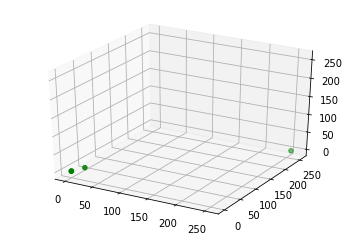

In [213]:
# n x m dimensional matrix which indicate the orthogonal projection points on the plane

# standard_fit(noAlpha)
print(standard_fit(noAlpha))

plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(reshaped, reshaped, reshaped, alpha=0.2)

# Ensure that the next plot doesn't overwrite the first plot
ax = plt.gca()
# ax.hold(True)

ax.scatter(noAlpha[0], noAlpha[1], color='green')

In [408]:
# # Height map of pixels on idividual channels
# c = 'centroid'
# n = 'normal vector'
# def F(p):
#     return np.dot((p - c), n)
# p = 'point'
# d = 'direction'
# # Pull out coordinates and desired channel
# d = np.zeros((5,), dtype=int)
# d[r] = 1
# # d = [0, 0, 1, 0, 0]
# t = ((np.dot(c,n) - np.dot(p,n))/(np.dot(d,n)))

def getIntPoints(c,n,ch,x,y):
#     d = np.zeros((5,), dtype=int)
#     d = np.zeros((3,))
#     d[ch] = 1
    d = [0.,0.,1.]
#     print(c,n,d)
    pointArray = []
    for i in x:
        for j in y:
            t = 0
            p = [i+1,j+1,0]
#             print('c*n=',np.dot(c,n),'p*n=', np.dot(p,n),'d*n=', np.dot(d,n))
            if((np.dot(d,n)) != 0):
                t = ((np.dot(c,n) - np.dot(p,n))/(np.dot(d,n)))            
#             print(t,d,t*d[2])
#             tempPoint = p[:,(t)] 
            tempPoint = [p[0],p[1],t] 
            print(tempPoint)
#             print('t=',t,'tempPoint=',tempPoint)
            pointArray.append(tempPoint)
    pA = np.asarray(pointArray)
    xP = pA[:,0]
    yP = pA[:,1]
    dP = pA[:,2]
    display(pA,xP,yP,dP)
    return xP,yP,dP


In [409]:
greenLayer = getChannel(reshaped, g)
c,n = (standard_fit(greenLayer))
print(c,n)
display(greenLayer)
pointCloud = getIntPoints(c,n,g,x,y)

[  7.5       3.5     127.59375] [-0.99801321 -0.00131278  0.0629914 ]


array([[  0,   0,  10],
       [  1,   0,  24],
       [  2,   0,  40],
       [  3,   0,  56],
       [  4,   0,  72],
       [  5,   0,  87],
       [  6,   0, 104],
       [  7,   0, 120],
       [  8,   0, 136],
       [  9,   0, 151],
       [ 10,   0, 168],
       [ 11,   0, 183],
       [ 12,   0, 199],
       [ 13,   0, 215],
       [ 14,   0, 231],
       [ 15,   0, 245],
       [  0,   1,  10],
       [  1,   1,  24],
       [  2,   1,  40],
       [  3,   1,  56],
       [  4,   1,  72],
       [  5,   1,  87],
       [  6,   1, 104],
       [  7,   1, 120],
       [  8,   1, 136],
       [  9,   1, 151],
       [ 10,   1, 168],
       [ 11,   1, 183],
       [ 12,   1, 199],
       [ 13,   1, 215],
       [ 14,   1, 231],
       [ 15,   1, 245],
       [  0,   2,  10],
       [  1,   2,  24],
       [  2,   2,  40],
       [  3,   2,  56],
       [  4,   2,  72],
       [  5,   2,  87],
       [  6,   2, 104],
       [  7,   2, 120],
       [  8,   2, 136],
       [  9,   2

[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 1, 24.55797976289834]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3,

[10, 7, 167.27579542125062]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[10, 8, 167.2966360058188]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 1, 182.99439326394636]
[11, 2, 183.01523384851455]
[11, 2, 183.01523384851455]
[11, 2, 183.01523384851455]
[11, 2, 

[3, 7, 56.37030597051699]
[3, 7, 56.37030597051699]
[3, 7, 56.37030597051699]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[3, 8, 56.39114655508516]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 1, 72.08890381321275]
[4, 2, 72.10974439778093]
[4, 2, 72.10974439778093]
[4, 2, 72.10974439778093]
[4, 2, 72.10

[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 4, 230.5878390679653]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 5, 230.60867965253348]
[14, 6, 230.6295202371017]
[14, 6, 230.6295202371017]
[14, 6, 230.6295202371017]
[14, 6, 230.6295202371017]
[14, 6, 230.6295202371017]
[14, 6, 230.6295202371017]
[14, 6, 230.

[10, 1, 167.1507519138416]
[10, 1, 167.1507519138416]
[10, 1, 167.1507519138416]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 2, 167.17159249840978]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 3, 167.1924330829779]
[10, 4, 167.2132736675461]
[10, 4, 167.

[4, 6, 72.19310673605362]
[4, 6, 72.19310673605362]
[4, 6, 72.19310673605362]
[4, 6, 72.19310673605362]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 7, 72.2139473206218]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[4, 8, 72.23478790518996]
[5, 1, 87.93254516331757]
[5, 1, 87.93254516331757]
[5, 1, 87.93254516331757]
[5

[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 7, 246.4940021717746]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[15, 8, 246.5148427563428]
[16, 1, 262.2126000144704]
[16, 1, 262.2126000144704]
[16, 1, 262.2126000144704]
[16, 1, 262.2126000144704]
[16, 1, 262.2126000144704]
[

[9, 3, 151.34879173287314]
[9, 3, 151.34879173287314]
[9, 3, 151.34879173287314]
[9, 3, 151.34879173287314]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 4, 151.36963231744127]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 5, 151.39047290200946]
[9, 6, 151.41131348657765]
[

[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 2, 24.57882034746651]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 3, 24.599660932034688]
[1, 4, 24.62050151660286]
[1, 4, 24.62050151660286]
[1, 4, 24.62050151660286]
[1, 4, 24.62050151660286]
[1, 4, 24.62050151660286]
[1, 4, 24.62050151660286]
[1, 4, 24.62050151660286]
[1, 4, 24.62050151660286]
[1, 4, 24.620501516602

[12, 7, 198.9630781214602]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[12, 8, 198.9839187060284]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 1, 214.681675964156]
[13, 2, 214.7025165487242]
[13, 2, 214.7025165487242]
[13, 2, 214.7025165487242]
[13, 2, 214.7025165487242]
[13, 2, 214.70251

[12, 4, 198.90055636775568]
[12, 4, 198.90055636775568]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 5, 198.92139695232387]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 6, 198.94223753689207]
[12, 7, 198.9630781214602]
[12, 7, 198.963078121

[8, 2, 135.48430979820014]
[8, 2, 135.48430979820014]
[8, 2, 135.48430979820014]
[8, 2, 135.48430979820014]
[8, 2, 135.48430979820014]
[8, 2, 135.48430979820014]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 3, 135.5051503827683]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.52599096733647]
[8, 4, 135.525990

array([[  1.        ,   1.        ,  24.55797976],
       [  1.        ,   1.        ,  24.55797976],
       [  1.        ,   1.        ,  24.55797976],
       ...,
       [ 16.        ,   8.        , 262.35848411],
       [ 16.        ,   8.        , 262.35848411],
       [ 16.        ,   8.        , 262.35848411]])

array([ 1.,  1.,  1., ..., 16., 16., 16.])

array([1., 1., 1., ..., 8., 8., 8.])

array([ 24.55797976,  24.55797976,  24.55797976, ..., 262.35848411,
       262.35848411, 262.35848411])

In [ ]:
display(pointCloud)

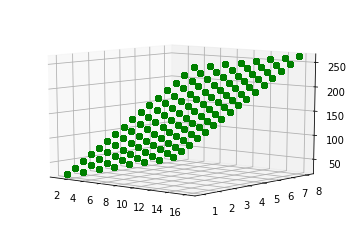

In [417]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

fig = plt.figure()
ax = plt.axes(projection='3d') 

xs,ys,zs = pointCloud
ax.plot(xs,ys,zs,'o',color='green')
ax.view_init(elev= 10, azim= - 50)
plt.show()